# XAI: Shap on the best model

In this notebook the shap technique is presented, along with the testing result for the best validation model.

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

# define basic files
FEATURES_DIR = os.path.join('..', 'data', 'features')
TRAIN_CSV_FILE = os.path.join('..', 'data', 'training_set.csv')
TEST_CSV_FILE = os.path.join('..', 'data', 'testing_set.csv')

# load the train data label
train_file = pd.read_csv(TRAIN_CSV_FILE)
test_file = pd.read_csv(TEST_CSV_FILE)

def load_subset_features( data, subset ):
    """ We load the pre-stored features"""
    features = np.load( os.path.join( FEATURES_DIR, subset_name + '.npy'), allow_pickle=True )[()]
    return [ features[fname] for fname in data['file'] ]

def get_fold_features( train_fold, valid_fold, subset_name):
    """ Load the extracted features, from the pre-stored files """
    features = np.load( os.path.join( FEATURES_DIR, subset_name + '.npy'), allow_pickle=True )[()]
    train_features = [ features[fname] for fname in train_fold['file'] ]
    valid_features = [ features[fname] for fname in valid_fold['file'] ]
    return train_features, valid_features

def get_raw_features( fold_data ):
    """ 
    Stack the features for a full-training on the features.
    We just need to concatenate the features for each sample.
    """
    fts_order = [ 'hu_bin', 'fourier_real', 'fourier_imag', 'stats', 'gabor', 'lbp', 'haralick' ]
    data_fts = [ np.concatenate([ sample[ftname] for ftname in fts_order] ) for sample in fold_data ]
    data_fts = np.stack( data_fts )
    data_fts[ np.isnan(data_fts) ] = 0
    return data_fts

## 1. Best SVM model:

Here we test the best `SVM` model from the grid search.

In [ ]:
best_params = {
    'n_estimators': 150, 
    'subset': 'medium_with_noise_not_inverted'
}

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from tqdm import tqdm

# make all the combinations for the experiments
rf_estimators = best_params['n_estimators']
data_subset = best_params['subset']
    
tfold_data, ttfold_data = train_file.copy(), test_file.copy()
tfold_Y, ttfold_Y = tfold_data['label'].values, ttfold_data['label'].values
tfold_fts, ttfold_fts = get_fold_features( tfold_data, ttfold_data, subset_name=data_subset )

# raw features
tfold_fts_raw = get_raw_features( tfold_fts )
ttfold_fts_raw = get_raw_features( ttfold_fts )
        
### Raw Testing
clf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=rf_estimators, class_weight='balanced'))
clf.fit( tfold_fts_raw, tfold_Y )
ttfold_raw_pred = clf.predict( ttfold_fts_raw )

raw_acc = clf.score( ttfold_fts_raw, ttfold_Y )
print("ACC:", raw_acc )

raw_f1 = f1_score( ttfold_Y, ttfold_raw_pred, average=None )
print("F1:", raw_f1 )

raw_f1_macro = f1_score( ttfold_Y, ttfold_raw_pred, average='macro')
print("F1 Macro:", raw_f1_macro )

ACC: 0.8128824476650564
F1: [0.86406397 0.83355177 0.23611111]
F1 Macro: 0.6445756167797388


Shap Analysis:

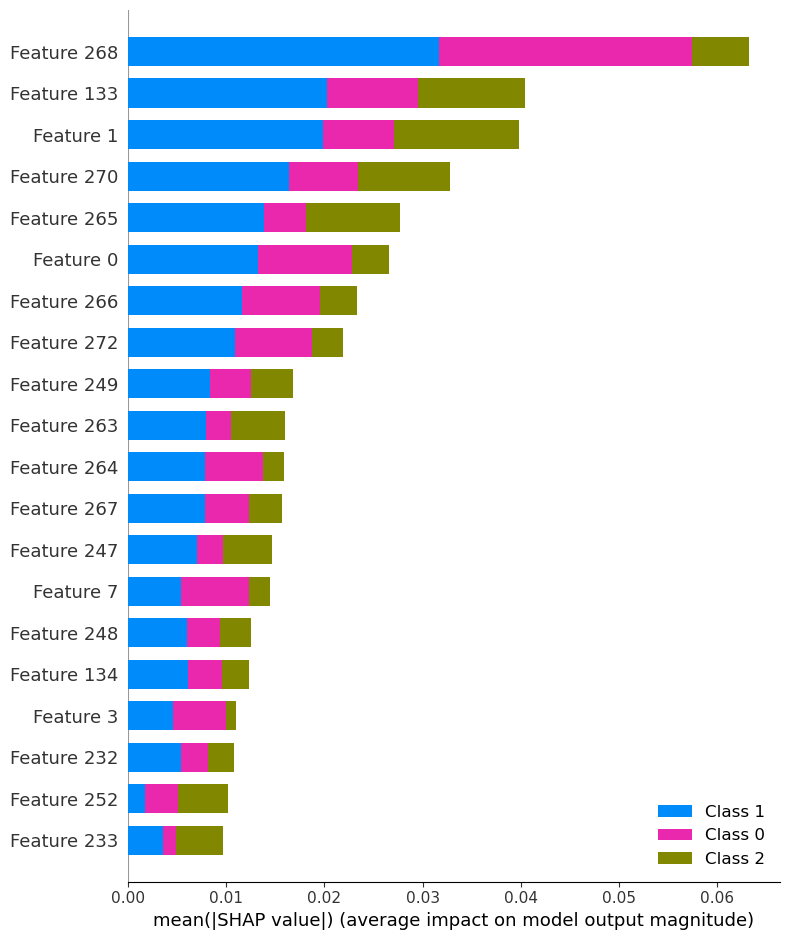

In [31]:
import shap

# Initialize the explainer with the model and the dataset
explainer = shap.Explainer(clf[1])

shap_values = explainer.shap_values(ttfold_fts_raw)
shap.summary_plot( shap_values, ttfold_fts_raw )

# shap.initjs()
# shap.force_plot( explainer.expected_value[1], shap_values[1], sample_instance )

In [34]:
shap_values[0]

array([[ 0.01118649, -0.00479158,  0.00392653, ...,  0.00428916,
         0.00565561, -0.00031623],
       [ 0.00363378, -0.01194894,  0.00108411, ...,  0.00289307,
         0.00764537,  0.00351273],
       [ 0.0073677 , -0.00511545,  0.00142806, ...,  0.00506548,
         0.00731981,  0.00149707],
       ...,
       [ 0.01113347, -0.00477883,  0.00021906, ...,  0.00357359,
         0.00803254,  0.00019826],
       [ 0.01107063, -0.0019647 ,  0.00309594, ...,  0.00676558,
         0.0047818 ,  0.00190781],
       [ 0.0072379 ,  0.0010378 ,  0.00197831, ...,  0.00393176,
         0.00659212,  0.00191746]])